# Import

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [2]:
#import data
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data


# Animal 0 Run

In [12]:
# Average across time and collapse (angle, sf) into a flat condition axis
TEST_DATA2D = resort_preprocessing(SATED_DECONV, SATED_ANGLE, SATED_SF, animal=0)[..., 40:80]
resp = jnp.nanmean(TEST_DATA2D, axis=-1).transpose(3, 1, 2, 0)  # K x C1 x C2 x N
resp = resp[~jnp.isnan(resp).any(axis=(1, 2, 3))]
K, C1, C2, N = resp.shape

angles = jnp.arange(C1)  # or jnp.arange(0, 360, 30) with period=360
sfs = jnp.array([0.02, 0.04, 0.08, 0.16, 0.32])
sfs = jnp.log2(sfs)
if C2 != len(sfs):
    raise ValueError("C2 does not match number of spatial frequencies")
X_FULL = jnp.stack(jnp.meshgrid(angles, sfs, indexing="ij"), axis=-1).reshape(-1, 2)

# X_FULL = jnp.stack(jnp.meshgrid(jnp.arange(C1), jnp.arange(C2), indexing="ij"), axis=-1).reshape(-1, 2)
Y_FULL = resp.reshape(K, C1 * C2, N)
print(X_FULL.shape)
print(Y_FULL.shape)
# Save files as NPZ
print(np.isnan(X_FULL).any())
print(np.isnan(Y_FULL).any())

x = np.asarray(X_FULL, dtype=np.float64)   # (C, 2)
y = np.asarray(Y_FULL, dtype=np.float64)   # (K, C, N)

# np.savez("data_sated_animal_1.npz", x=x, y=y)

print("saved:", "data_sated_animal_1.npz")
print("x:", x.shape, x.dtype)
print("y:", y.shape, y.dtype)
print("K:", K, "C:", C1*C2, "N:", N,C1)

(60, 2)
(10, 60, 137)
False
False
saved: data_sated_animal_1.npz
x: (60, 2) float64
y: (10, 60, 137) float64
K: 10 C: 60 N: 137 12


In [3]:
import_data = np.load('data_sated_animal_1.npz')
X_FULL = import_data['x']
Y_FULL = import_data['y']


# Hyperparam check

Runs loaded: 201 (status=='ok': 201)
Best run: id=153  val_loglik=130.37799500245734
Best model_P: 2

Top 10 by val_loglik:
 id  val_loglik status  source  model_P  gp_angle_gamma  gp_angle_beta  gp_angle_lambda  gp_sf_gamma  gp_sf_beta  gp_sf_lambda  wp_angle_gamma  wp_angle_beta  wp_angle_lambda  wp_sf_gamma  wp_sf_beta  wp_sf_lambda  is_best
153  130.377995     ok results        2        0.000021       0.014799         0.022095     0.000945    0.001144      9.688436        0.000007       0.139527         0.085482     0.000015    0.024132      3.698828     True
153  130.377995     ok    best        2        0.000021       0.014799         0.022095     0.000945    0.001144      9.688436        0.000007       0.139527         0.085482     0.000015    0.024132      3.698828     True
 66  123.015237     ok results        1        0.000004       0.002244         0.029949     0.000485    0.004082      0.336299        0.004328       0.016225         2.676275     0.000005    0.208418      0.

/tmp/ipykernel_148430/3969739028.py:46: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


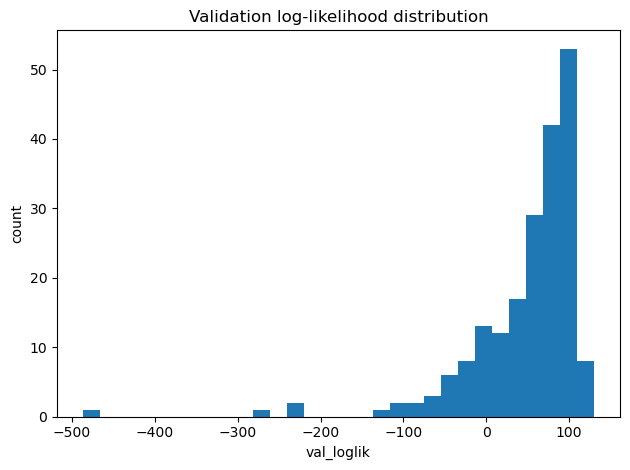

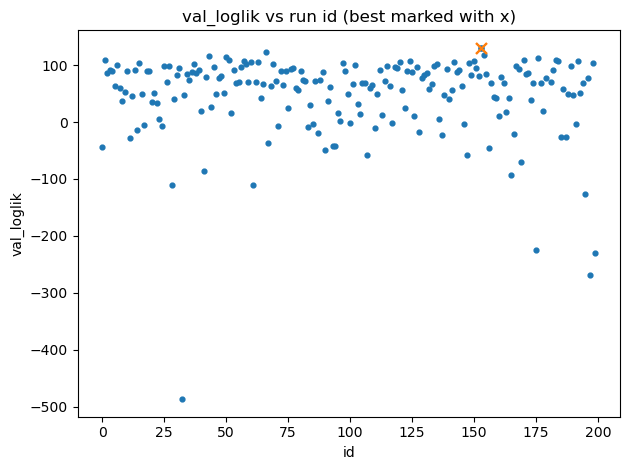

/tmp/ipykernel_148430/3969739028.py:179: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=True)


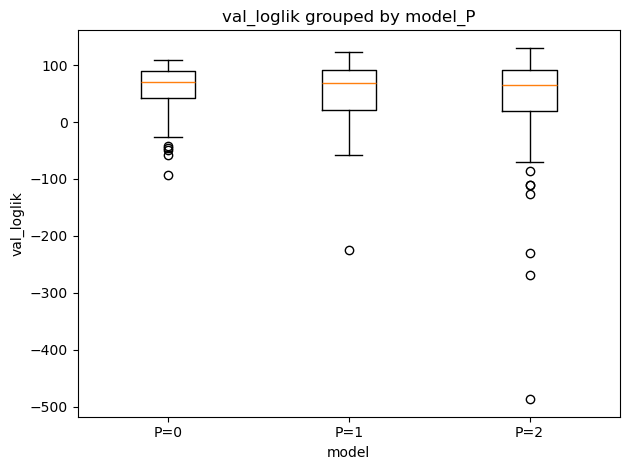

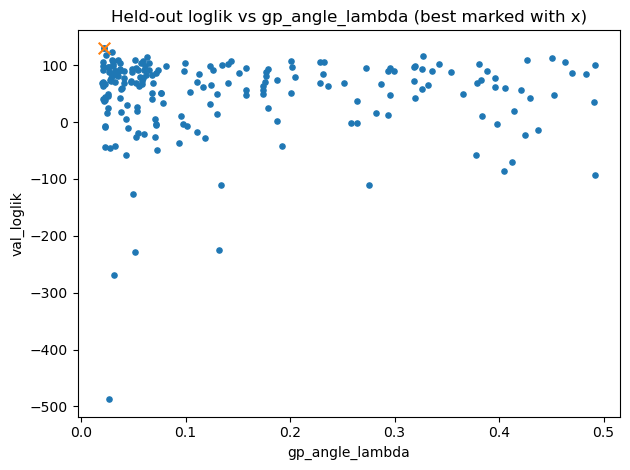


Top lambda values for gp_angle_lambda by max val_loglik:
gp_angle_lambda
0.022095    130.377995
0.029949    123.015237
0.023535    117.784896
0.327374    116.964113
0.062833    114.432869
0.451035    112.717275
0.035204    109.817818
0.426379    109.461382
0.051765    108.720339
0.029157    108.329686


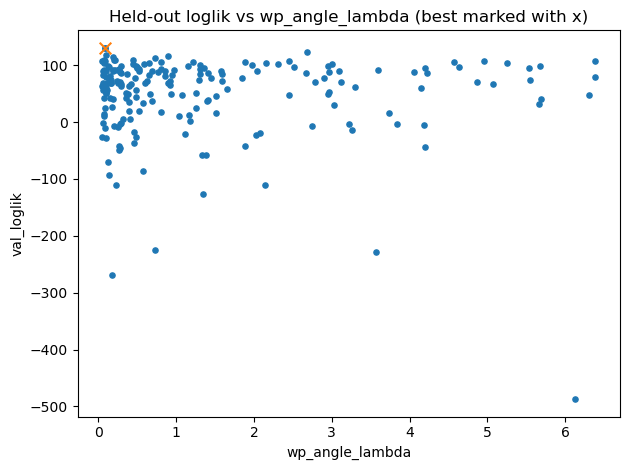


Top lambda values for wp_angle_lambda by max val_loglik:
wp_angle_lambda
0.085482    130.377995
2.676275    123.015237
0.091949    117.784896
0.894215    116.964113
0.188703    114.432869
0.722478    112.717275
0.214055    109.817818
0.203888    109.461382
0.077008    108.720339
0.446089    108.329686


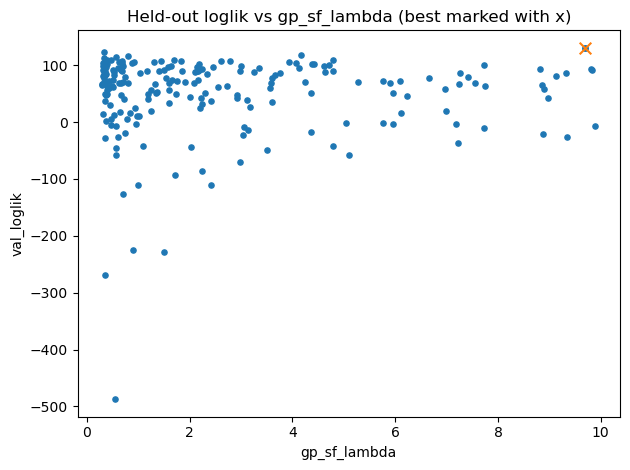


Top lambda values for gp_sf_lambda by max val_loglik:
gp_sf_lambda
9.688436    130.377995
0.336299    123.015237
4.165081    117.784896
0.803256    116.964113
0.573569    114.432869
0.337035    112.717275
0.463863    109.817818
1.693487    109.461382
0.400905    108.720339
4.780816    108.329686


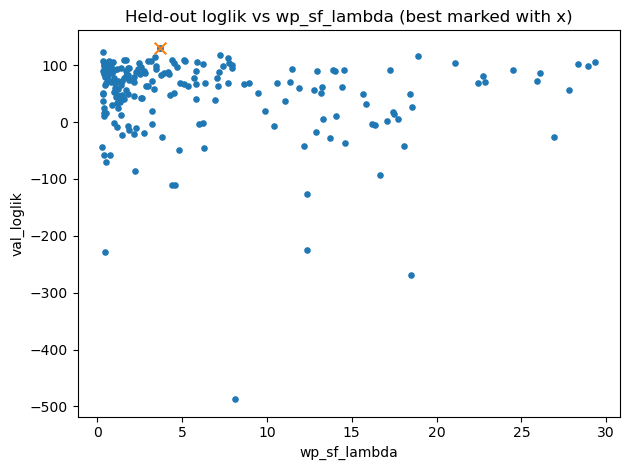


Top lambda values for wp_sf_lambda by max val_loglik:
wp_sf_lambda
3.698828     130.377995
0.322068     123.015237
7.210535     117.784896
18.923996    116.964113
3.384210     114.432869
7.683572     112.717275
5.103774     109.817818
1.579775     109.461382
4.412620     108.720339
1.700331     108.329686


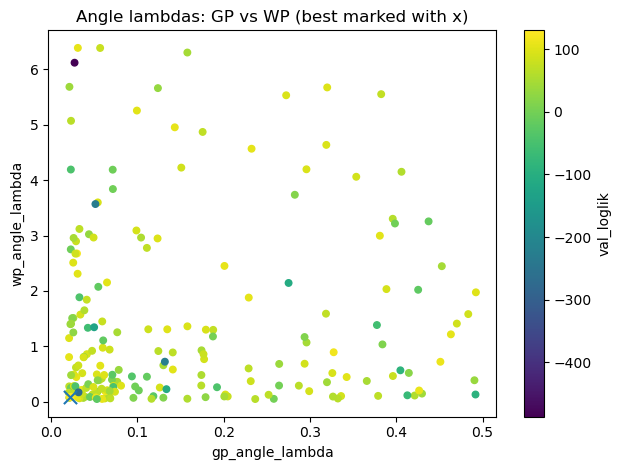


Top (GP, WP) lambda pairs for Angle lambdas: GP vs WP by max val_loglik:
gp_angle_lambda  wp_angle_lambda
0.022095         0.085482           130.377995
0.029949         2.676275           123.015237
0.023535         0.091949           117.784896
0.327374         0.894215           116.964113
0.062833         0.188703           114.432869
0.451035         0.722478           112.717275
0.035204         0.214055           109.817818
0.426379         0.203888           109.461382
0.051765         0.077008           108.720339
0.029157         0.446089           108.329686


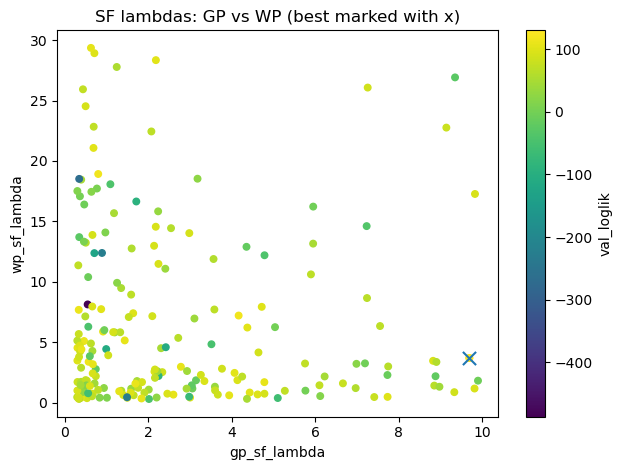


Top (GP, WP) lambda pairs for SF lambdas: GP vs WP by max val_loglik:
gp_sf_lambda  wp_sf_lambda
9.688436      3.698828        130.377995
0.336299      0.322068        123.015237
4.165081      7.210535        117.784896
0.803256      18.923996       116.964113
0.573569      3.384210        114.432869
0.337035      7.683572        112.717275
0.463863      5.103774        109.817818
1.693487      1.579775        109.461382
0.400905      4.412620        108.720339
4.780816      1.700331        108.329686


In [29]:
#Load Json file and evaluate statistics
"""
Show + plot results from your hyperparameter sweep JSON.

Usage:
  1) Save your JSON output to a file, e.g.  analysis_results.json
  2) Run:  python show_analysis_results.py analysis_results.json
     (or just run this cell in a notebook and set PATH below)

What it does:
  - Loads JSON
  - Flattens nested params into columns (gp_angle_gamma, wp_sf_lambda, model_P, ...)
  - Builds a DataFrame, sorts by val_loglik
  - Prints a quick summary + top-N table
  - Makes a few matplotlib plots (histogram, scatter, boxplot by model_P)
"""

from __future__ import annotations

import json
import sys
from pathlib import Path
from typing import Any, Dict, Iterable, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def _flatten_dict(d: Dict[str, Any], prefix: str = "") -> Dict[str, Any]:
    """Recursively flatten a nested dict into {prefix_key: value}."""
    out: Dict[str, Any] = {}
    for k, v in (d or {}).items():
        key = f"{prefix}_{k}" if prefix else str(k)
        if isinstance(v, dict):
            out.update(_flatten_dict(v, key))
        else:
            out[key] = v
    return out


def _coerce_numeric_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Try to convert object columns to numeric where possible."""
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c], errors="ignore")
    # model_P often comes as a string like "2"
    if "model_P" in df.columns:
        df["model_P"] = pd.to_numeric(df["model_P"], errors="coerce").astype("Int64")
    return df


def load_analysis(path: str | Path) -> Dict[str, Any]:
    path = Path(path)
    data = json.loads(path.read_text())
    if not isinstance(data, dict):
        raise ValueError("Top-level JSON should be an object/dict.")
    return data


def build_dataframe(data: Dict[str, Any]) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    results = data.get("results", []) or []
    best = data.get("best", {}) or {}

    rows = []
    for r in results:
        base = {
            "id": r.get("id"),
            "val_loglik": r.get("val_loglik"),
            "status": r.get("status"),
            "source": "results",
        }
        params = _flatten_dict(r.get("params", {}), "")
        rows.append({**base, **params})

    # Add "best" as its own row (often best.id isn't in the truncated results list)
    if best:
        base_best = {
            "id": best.get("id"),
            "val_loglik": best.get("val_loglik"),
            "status": best.get("status"),
            "source": "best",
        }
        params_best = _flatten_dict(best.get("params", {}), "")
        rows.append({**base_best, **params_best})

    df = pd.DataFrame(rows)
    df = _coerce_numeric_cols(df)

    # Mark best row explicitly
    best_id = best.get("id", None)
    df["is_best"] = False
    if best_id is not None:
        df.loc[df["id"] == best_id, "is_best"] = True

    return df, best


def print_summary(df: pd.DataFrame, best: Dict[str, Any], top_n: int = 10) -> None:
    ok = df["status"].astype(str).eq("ok").sum() if "status" in df else len(df)
    print(f"Runs loaded: {len(df)} (status=='ok': {ok})")

    if best:
        print(f"Best run: id={best.get('id')}  val_loglik={best.get('val_loglik')}")
        print(f"Best model_P: {best.get('params', {}).get('model', {}).get('P')}")
    print()

    cols_prefer = [
        "id",
        "val_loglik",
        "status",
        "source",
        "model_P",
        "gp_angle_gamma",
        "gp_angle_beta",
        "gp_angle_lambda",
        "gp_sf_gamma",
        "gp_sf_beta",
        "gp_sf_lambda",
        "wp_angle_gamma",
        "wp_angle_beta",
        "wp_angle_lambda",
        "wp_sf_gamma",
        "wp_sf_beta",
        "wp_sf_lambda",
        "is_best",
    ]
    cols = [c for c in cols_prefer if c in df.columns]
    top = df.sort_values("val_loglik", ascending=False).head(top_n)
    print(f"Top {top_n} by val_loglik:")
    print(top[cols].to_string(index=False))
    print()


def plot_loglik_distribution(df: pd.DataFrame) -> None:
    x = pd.to_numeric(df["val_loglik"], errors="coerce").dropna().values
    plt.figure()
    plt.hist(x, bins=30)
    plt.xlabel("val_loglik")
    plt.ylabel("count")
    plt.title("Validation log-likelihood distribution")
    plt.tight_layout()
    plt.show()


def plot_loglik_vs_id(df: pd.DataFrame) -> None:
    x = pd.to_numeric(df["id"], errors="coerce")
    y = pd.to_numeric(df["val_loglik"], errors="coerce")
    m = x.notna() & y.notna()
    plt.figure()
    plt.scatter(x[m], y[m], s=12)
    # highlight best
    if "is_best" in df.columns and df["is_best"].any():
        b = df["is_best"] & m
        plt.scatter(x[b], y[b], s=60, marker="x")
    plt.xlabel("id")
    plt.ylabel("val_loglik")
    plt.title("val_loglik vs run id (best marked with x)")
    plt.tight_layout()
    plt.show()


def plot_by_modelP(df: pd.DataFrame) -> None:
    if "model_P" not in df.columns:
        print("No model_P column found; skipping boxplot.")
        return
    tmp = df.copy()
    tmp["model_P"] = pd.to_numeric(tmp["model_P"], errors="coerce")
    tmp["val_loglik"] = pd.to_numeric(tmp["val_loglik"], errors="coerce")
    tmp = tmp.dropna(subset=["model_P", "val_loglik"])

    groups = []
    labels = []
    for p in sorted(tmp["model_P"].unique()):
        groups.append(tmp.loc[tmp["model_P"] == p, "val_loglik"].values)
        labels.append(f"P={int(p)}")

    plt.figure()
    plt.boxplot(groups, labels=labels, showfliers=True)
    plt.xlabel("model")
    plt.ylabel("val_loglik")
    plt.title("val_loglik grouped by model_P")
    plt.tight_layout()
    plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _num(s):
    return pd.to_numeric(s, errors="coerce")

def plot_lambdas(df: pd.DataFrame, top_k: int = 1) -> None:
    """
    Plots showing which GP/WP lambda values yield best held-out log-likelihood.
    - 1D: val_loglik vs each lambda
    - 2D: gp_lambda vs wp_lambda (angle and sf), colored by val_loglik
    """
    # Coerce numerics
    df = df.copy()
    for c in ["val_loglik", "gp_angle_lambda", "gp_sf_lambda", "wp_angle_lambda", "wp_sf_lambda"]:
        if c in df.columns:
            df[c] = _num(df[c])

    # Keep rows with val_loglik
    df = df.dropna(subset=["val_loglik"])

    # Identify best row
    best_idx = df["val_loglik"].idxmax()
    best_row = df.loc[best_idx]

    # --- 1D plots: val_loglik vs each lambda ---
    for lam_col in ["gp_angle_lambda", "wp_angle_lambda", "gp_sf_lambda", "wp_sf_lambda"]:
        if lam_col not in df.columns:
            continue
        tmp = df.dropna(subset=[lam_col])

        plt.figure()
        plt.scatter(tmp[lam_col].values, tmp["val_loglik"].values, s=14)

        # Mark best (if it has this lambda)
        if pd.notna(best_row.get(lam_col, np.nan)):
            plt.scatter([best_row[lam_col]], [best_row["val_loglik"]], s=70, marker="x")

        plt.xlabel(lam_col)
        plt.ylabel("val_loglik")
        plt.title(f"Held-out loglik vs {lam_col} (best marked with x)")
        plt.tight_layout()
        plt.show()

        # Optional: show "best per lambda value" table in stdout
        # (Handy if lambdas are on a discrete grid.)
        grp = (tmp.groupby(lam_col, dropna=True)["val_loglik"]
                 .max()
                 .sort_values(ascending=False)
                 .head(10))
        print(f"\nTop lambda values for {lam_col} by max val_loglik:")
        print(grp.to_string())

    # --- 2D plots: gp_lambda vs wp_lambda, colored by val_loglik ---
    def plot_2d(gp_col: str, wp_col: str, title: str) -> None:
        if gp_col not in df.columns or wp_col not in df.columns:
            return
        tmp = df.dropna(subset=[gp_col, wp_col])

        plt.figure()
        sc = plt.scatter(tmp[gp_col].values, tmp[wp_col].values, c=tmp["val_loglik"].values, s=22)
        plt.colorbar(sc, label="val_loglik")

        # Mark best if available
        if pd.notna(best_row.get(gp_col, np.nan)) and pd.notna(best_row.get(wp_col, np.nan)):
            plt.scatter([best_row[gp_col]], [best_row[wp_col]], s=90, marker="x")

        plt.xlabel(gp_col)
        plt.ylabel(wp_col)
        plt.title(title + " (best marked with x)")
        plt.tight_layout()
        plt.show()

        # Optional: best per (gp, wp) pair
        best_pairs = (tmp.groupby([gp_col, wp_col], dropna=True)["val_loglik"]
                        .max()
                        .sort_values(ascending=False)
                        .head(10))
        print(f"\nTop (GP, WP) lambda pairs for {title} by max val_loglik:")
        print(best_pairs.to_string())

    plot_2d("gp_angle_lambda", "wp_angle_lambda", "Angle lambdas: GP vs WP")
    plot_2d("gp_sf_lambda",    "wp_sf_lambda",    "SF lambdas: GP vs WP")

def main() -> None:
    # if len(argv) >= 2:
        # path = argv[1]
    # else:
    path = "results.json"  # <- change this if running in a notebook

    data = load_analysis(path)
    df, best = build_dataframe(data)

    # Keep only ok runs for plots (optional)
    if "status" in df.columns:
        df_ok = df[df["status"].astype(str) == "ok"].copy()
    else:
        df_ok = df

    print_summary(df_ok, best, top_n=10)

    # If you're in a notebook, df_ok is the nice table to explore:
    # display(df_ok.sort_values("val_loglik", ascending=False))

    plot_loglik_distribution(df_ok)
    plot_loglik_vs_id(df_ok)
    plot_by_modelP(df_ok)
    plot_lambdas(df_ok)

if __name__ == "__main__":
    main()


In [8]:
import json

def load_best_hyperparams(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    p = data["best"]["params"]

    hyperparams = {
        "lambda_gp_angle": p["gp"]["angle"]["lambda"],
        "gamma_gp_angle":  p["gp"]["angle"]["gamma"],
        "beta_gp_angle":   p["gp"]["angle"]["beta"],

        "lambda_gp_sf": p["gp"]["sf"]["lambda"],
        "gamma_gp_sf":  p["gp"]["sf"]["gamma"],
        "beta_gp_sf":   p["gp"]["sf"]["beta"],

        "lambda_wp_angle": p["wp"]["angle"]["lambda"],
        "gamma_wp_angle":  p["wp"]["angle"]["gamma"],
        "beta_wp_angle":   p["wp"]["angle"]["beta"],

        "lambda_wp_sf": p["wp"]["sf"]["lambda"],
        "gamma_wp_sf":  p["wp"]["sf"]["gamma"],
        "beta_wp_sf":   p["wp"]["sf"]["beta"],

        "p": p["model"]["P"],
    }

    return hyperparams


In [30]:
import json

def _find_record_by_id(obj, target_id):
    """Recursive fallback: find first dict that has obj['id'] == target_id."""
    if isinstance(obj, dict):
        if str(obj.get("id")) == str(target_id):
            return obj
        for v in obj.values():
            hit = _find_record_by_id(v, target_id)
            if hit is not None:
                return hit
    elif isinstance(obj, list):
        for item in obj:
            hit = _find_record_by_id(item, target_id)
            if hit is not None:
                return hit
    return None

def load_hyperparams_from_id(json_path, run_id: int):
    with open(json_path, "r") as f:
        data = json.load(f)

    record = None

    # Common shapes: {"runs":[...]} / {"trials":[...]} / {"results":[...]}
    if isinstance(data, dict):
        for key in ("runs", "trials", "results", "history"):
            if key in data and isinstance(data[key], list):
                record = next((r for r in data[key] if str(r.get("id")) == str(run_id)), None)
                if record is not None:
                    break

        # Another common shape: {"results": {"50": {...}}}
        if record is None and isinstance(data.get("results"), dict) and str(run_id) in data["results"]:
            record = data["results"][str(run_id)]

    # If the whole file is a list of records
    if record is None and isinstance(data, list):
        record = next((r for r in data if str(r.get("id")) == str(run_id)), None)

    # Last resort: deep search anywhere
    if record is None:
        record = _find_record_by_id(data, run_id)

    if record is None:
        raise KeyError(f"Could not find any record with id={run_id} in {json_path}")

    # Where are the params stored?
    params = (
        record.get("params")
        or record.get("hyperparams")
        or (record.get("best", {}) or {}).get("params")
    )
    if params is None:
        raise KeyError(f"Found record id={run_id}, but couldn't find params in it.")

    p = params  # expected nested structure: p["gp"]["angle"]["lambda"], etc.

    hyperparams = {
        "lambda_gp_angle": p["gp"]["angle"]["lambda"],
        "gamma_gp_angle":  p["gp"]["angle"]["gamma"],
        "beta_gp_angle":   p["gp"]["angle"]["beta"],
        "lambda_gp_sf":    p["gp"]["sf"]["lambda"],
        "gamma_gp_sf":     p["gp"]["sf"]["gamma"],
        "beta_gp_sf":      p["gp"]["sf"]["beta"],
        "lambda_wp_angle": p["wp"]["angle"]["lambda"],
        "gamma_wp_angle":  p["wp"]["angle"]["gamma"],
        "beta_wp_angle":   p["wp"]["angle"]["beta"],
        "lambda_wp_sf":    p["wp"]["sf"]["lambda"],
        "gamma_wp_sf":     p["wp"]["sf"]["gamma"],
        "beta_wp_sf":      p["wp"]["sf"]["beta"],
        "p":               p["model"]["P"],
    }

    return hyperparams, record


# Simple 2D Run

In [4]:
# Split trials/conditions
SEED = 1
split = utils.split_data(
    x=X_FULL,
    y=Y_FULL,
    train_trial_prop=0.8,
    train_condition_prop=0.8,
    seed=SEED,
)
x_tr, y_tr, _, _, x_te, y_te, *_ = split
x_tr, x_te = jnp.asarray(x_tr), jnp.asarray(x_te)  # keep shape (#cond, 2)



In [39]:
# Hyperparameters (given)
hyperparams = {
    'lambda_gp_angle': 1.8103336,
    'gamma_gp_angle': 4.5379544e-05,
    'beta_gp_angle': 0.12863505,

    'lambda_gp_sf': 0.26290625,
    'gamma_gp_sf': 0.00011522,
    'beta_gp_sf': 0.1991709,

    'lambda_wp_angle': 0.22797374,
    'gamma_wp_angle': 0.00010354,
    'beta_wp_angle': 1.6773869,

    'lambda_wp_sf': 0.36553314,
    'gamma_wp_sf': 2.8193786e-05,
    'beta_wp_sf': 0.27211133,

    'p': 1
}

# hyperparams = load_best_hyperparams("results.json")
# hyperparams, rec50 = load_hyperparams_from_id("results.json", 176)
# print(hyperparams)
# print(rec50)

In [42]:
V_SCALE = 1e-1
ADAM_OPT = 1e-2
ITERATIONS = 50000
NMC = 32
PERIOD = C1

# Kernels
periodic_gp_angle = lambda a, b: hyperparams["gamma_gp_angle"] * (a == b) + hyperparams["beta_gp_angle"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / PERIOD) ** 2 / hyperparams["lambda_gp_angle"]
)
square_gp_sf = lambda a, b: hyperparams["gamma_gp_sf"] * (a == b) + hyperparams["beta_gp_sf"] * jnp.exp(
    -(a - b) ** 2 / hyperparams["lambda_gp_sf"]
)
kernel_gp = lambda x, y: periodic_gp_angle(x[0], y[0]) * square_gp_sf(x[1], y[1])

periodic_wp_angle = lambda a, b: hyperparams["gamma_wp_angle"] * (a == b) + hyperparams["beta_wp_angle"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / PERIOD) ** 2 / hyperparams["lambda_wp_angle"]
)
square_wp_sf = lambda a, b: hyperparams["gamma_wp_sf"] * (a == b) + hyperparams["beta_wp_sf"] * jnp.exp(
    -(a - b) ** 2 / hyperparams["lambda_wp_sf"]
)
kernel_wp = lambda x, y: periodic_wp_angle(x[0], y[0]) * square_wp_sf(x[1], y[1])

gp = models.GaussianProcess(kernel=kernel_gp, N=N)
wp = models.WishartLRDProcess(kernel=kernel_wp, P=int(hyperparams["p"]), V=V_SCALE * jnp.eye(N), optimize_L=True)

# Init L from train covariance
y_flat = y_tr.reshape(-1, N)
y_flat = y_flat - y_flat.mean(0, keepdims=True)
Sigma_bar = (y_flat.T @ y_flat) / (y_flat.shape[0] - 1)
eps = 1e-3 * jnp.trace(Sigma_bar) / N
wp.L = jnp.linalg.cholesky(Sigma_bar + eps * jnp.eye(N))

lik = models.NormalConditionalLikelihood(N)
joint = models.JointGaussianWishartProcess(gp, wp, lik)

# Variational inference
guide = inference.VariationalNormal(joint.model)
guide.infer(optim.Adam(ADAM_OPT), x_tr, y_tr, n_iter=ITERATIONS, key=jax.random.PRNGKey(SEED))
joint.update_params(guide.posterior)
posterior = models.NormalGaussianWishartPosterior(joint, guide, x_tr)

# Held-out log-likelihood
y_obs = y_te["x_test"]
def one_draw(rng):
    with numpyro.handlers.seed(rng_seed=rng):
        mu, Sigma, _ = posterior.sample(x_te)
    return lik.log_prob(y_obs, mu, Sigma).mean()

mc_keys = jax.random.split(jax.random.PRNGKey(SEED), NMC)
print("Held-out mean log-lik:", float(jax.vmap(one_draw)(mc_keys).mean()))

100%|██████████| 50000/50000 [10:11<00:00, 81.79it/s, init loss: 47275434739.5156, avg. loss [47501-50000]: 6530.2300]   


Held-out mean log-lik: 82.32027532624997


In [43]:
print("loss finite?", jnp.isfinite(guide.losses).all())


loss finite? True


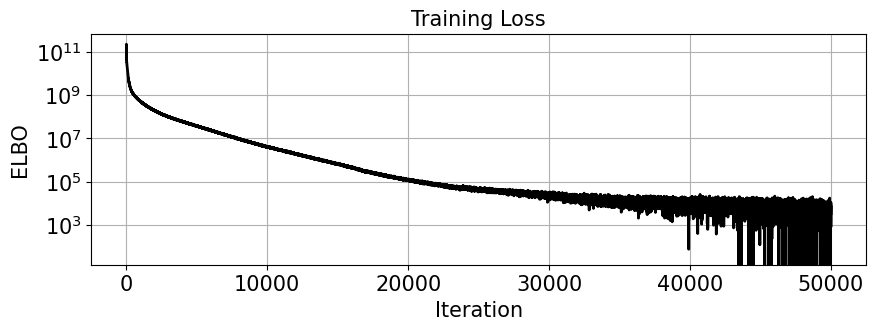

In [44]:
# %% Visualization
visualizations.plot_loss(
    [guide.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

finite? True True
mu_hat shape: (60, 1, 137)
sigma_hat shape: (60, 137, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


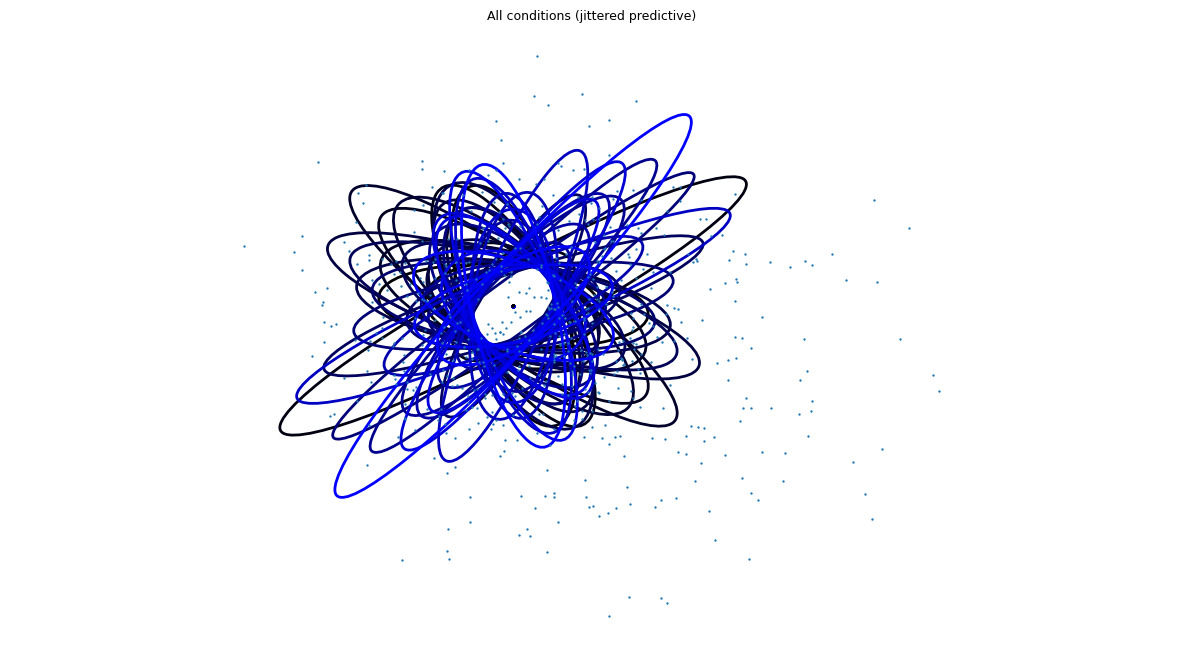

In [47]:
import numpy as np
import numpyro
import numpyro.distributions as dist


def gp_predict_jitter(gp, X, Y, x, base=1e-12):
    K_X_X = gp.evaluate_kernel(X, X)
    scale = float(jnp.mean(jnp.diag(K_X_X)))
    jitter = base * max(scale, 1.0)
    K_X_X = K_X_X + jitter * jnp.eye(len(X))
    K_X_x = gp.evaluate_kernel(x, X)
    K_x_x = gp.evaluate_kernel(x, x) + jitter * jnp.eye(len(x))

    Ki = jnp.linalg.inv(K_X_X)
    f = jnp.einsum('ij,jm->mi', K_X_x.T @ Ki, Y)
    K = K_x_x - K_X_x.T @ Ki @ K_X_x + jitter * jnp.eye(len(x))
    return f, K

def wp_predict_jitter(wp, X, F, x, base=1e-12, key=jax.random.PRNGKey(0)):
    K_X_X = wp.evaluate_kernel(X, X)
    scale = float(jnp.mean(jnp.diag(K_X_X)))
    jitter = base * max(scale, 1.0)
    K_X_X = K_X_X + jitter * jnp.eye(len(X))
    K_X_x = wp.evaluate_kernel(x, X)
    K_x_x = wp.evaluate_kernel(x, x) + jitter * jnp.eye(len(x))

    Ki = jnp.linalg.inv(K_X_X)
    f = jnp.einsum('ij,mnj->mni', K_X_x.T @ Ki, F)
    K = K_x_x - K_X_x.T @ Ki @ K_X_x + jitter * jnp.eye(len(x))
    F_new = dist.MultivariateNormal(f, covariance_matrix=K).sample(key)
    sigma = wp.f2sigma(F_new)
    return F_new, sigma


# 1) Sample posterior on all conditions with jitter
with numpyro.handlers.seed(rng_seed=0):
    F_draw, G_draw = guide.sample()  # VI draw from trained guide

mu_hat, _ = gp_predict_jitter(joint.gp, x_tr, G_draw.squeeze().T, X_FULL)
F_pred, sigma_hat = wp_predict_jitter(joint.wp, x_tr, F_draw, X_FULL, key=jax.random.PRNGKey(1))

print("finite?", np.isfinite(mu_hat).all(), np.isfinite(sigma_hat).all())

# 2) Point cloud from data
mu_hatT = np.asarray(mu_hat).T
mu_hatNEW = mu_hatT.reshape(mu_hatT.shape[0], 1,mu_hatT.shape[1])
sigma_hat = np.asarray(sigma_hat)

print("mu_hat shape:", mu_hatNEW.shape)
print("sigma_hat shape:", sigma_hat.shape)

visualizations.visualize_pc(
    mu_hatNEW,
    sigma_hat,
    pc=Y_FULL.reshape(-1, N),
    title_str="All conditions (jittered predictive)",
    dotsize=10,
    std=0.1,
)

(60, 1, 137)
mu_ring shape: (12, 1, 137)
sigma_ring shape: (12, 137, 137)
pc_cloud shape: (120, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


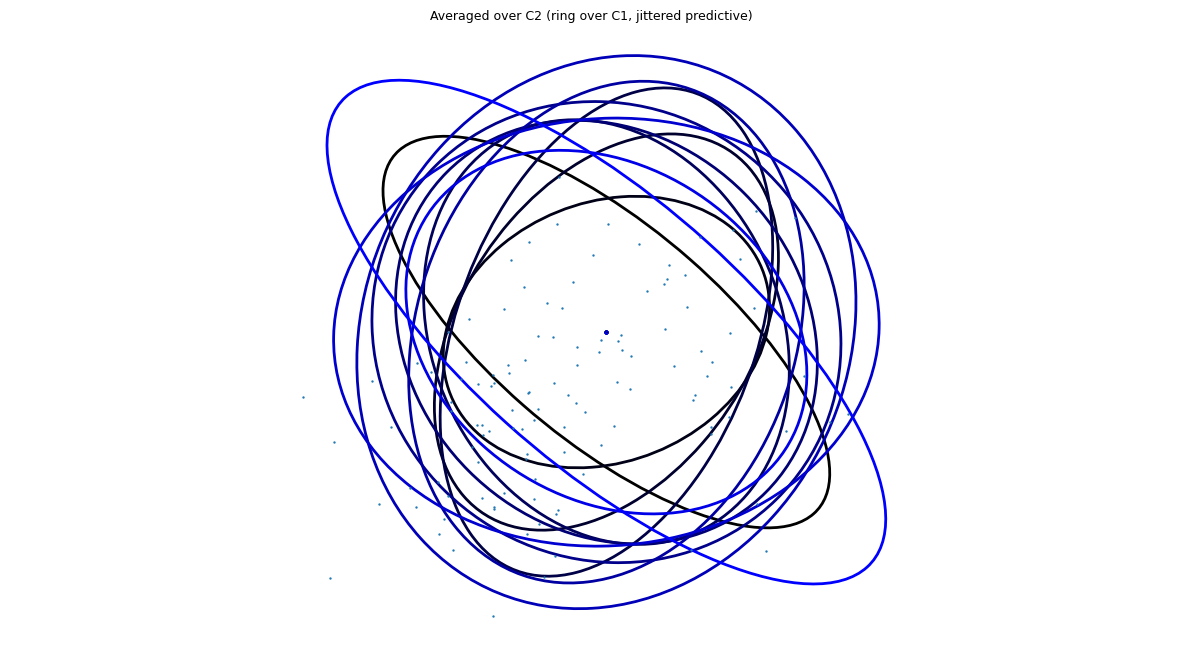

: 

In [ ]:
print(mu_hatNEW.shape)
mu_ring = mu_hatNEW.reshape(C1, C2,1, N).mean(axis=1)


print("mu_ring shape:", mu_ring.shape)
sigma_ring = sigma_hat.reshape(C1, C2, N, N).mean(axis=1)
print("sigma_ring shape:", sigma_ring.shape)

Y_FULL_average = Y_FULL.reshape(K, C1, C2, N).mean(axis=2)
pc_cloud = Y_FULL_average.reshape(K*C1,-1)
print("pc_cloud shape:", pc_cloud.shape)
visualizations.visualize_pc(
    mu_ring,
    sigma_ring,
    pc=pc_cloud,
    title_str="Averaged over C2 (ring over C1, jittered predictive)",
    dotsize=12,
    std=0.1,
)

# Compare covariance to emprircal

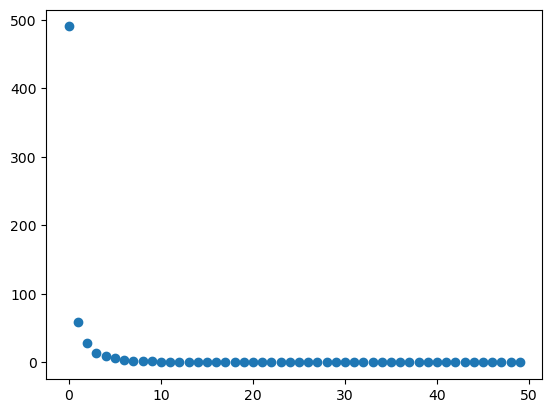

In [88]:
evals_store = np.zeros((12,50))
for iangle in range(12):
    cov_matrix = sigma_ring[iangle,:,:]
    eval, evec = np.linalg.eigh(cov_matrix)
    non_zero_evals = eval[::-1]
    evals_store[iangle,:] = non_zero_evals[:50]
    # plt.scatter(np.arange(len(non_zero_evals)), non_zero_evals)
    # plt.title(f'Angle {iangle}')
    # plt.show()
average_evals = np.mean(evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_evals)), average_evals)





(0.0, 0.5)

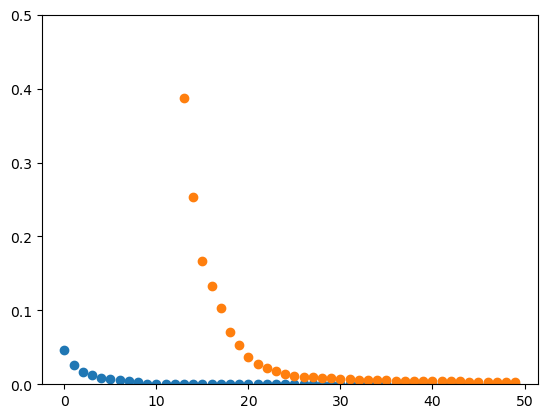

In [89]:
raw_evals_store = np.zeros((12,50))
for iangle in range(12):
    test = Y_FULL_average[:,iangle,:]  # shape (K, N)
    covariance_matrix = np.cov(test, rowvar=False)  # shape (N, N)
    eval, evec = np.linalg.eigh(covariance_matrix)
    non_zero_evals = eval[::-1]
    raw_evals_store[iangle,:] = non_zero_evals[:50]
average_raw_evals = np.mean(raw_evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_raw_evals)), average_raw_evals)
plt.scatter(np.arange(len(average_evals)), average_evals)
plt.ylim(0,0.5)



(12, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


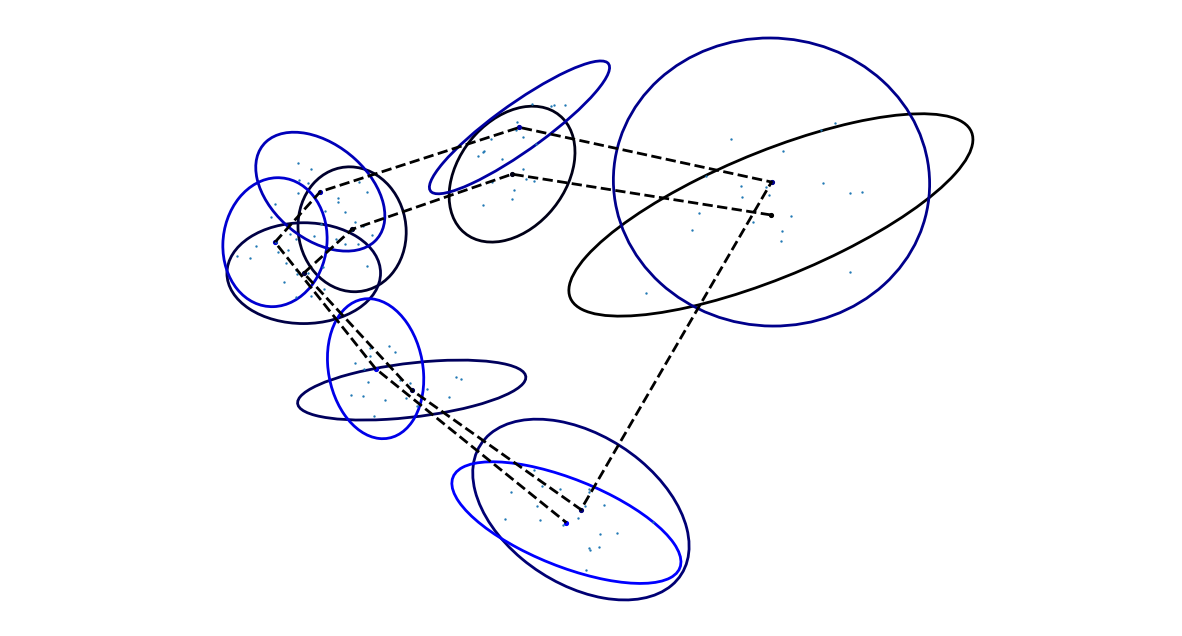

In [90]:
import pandas as pd
empirical_mu = jnp.nanmean(Y_FULL_average,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = Y_FULL_average[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=Y_FULL_average.reshape(Y_FULL_average.shape[0]*Y_FULL_average.shape[1],-1)
)
